In [1]:
import pandas as pd
import numpy as np
from math import pi

import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, normalize
from sklearn.linear_model import LinearRegression
import pingouin as pg
from sklearn.model_selection import train_test_split, cross_val_score

from eda_helpers import normality_check, count_outliers
from stat_inference_helpers import custom_corr, evaluate_model

**1. Start from the Summary coming from the Exploratory Data Analysis (EDA)**

**Summary:**
 - Target: `Price` numerical continuous variable;
 - There are 6 features: 4 continuous, 2 text;
 - There are 3 missing values in target variable;
 - There are no missing values in features;
 - `Price`, `Area` and `Room` have right-skewed distribution and 56, 33, 62 outliers respectively. However if we look closer to these outliers, we'll see that all of them are just big (and thus expencive) houses. These values will not be considered as outliers;
 - There are 2 outiers in `Longitude`, that are much lower than the mean;
 - Outliers of `Latitude` create a cluster togeter with other points and will not be considered as outliers.
 - There is one point, which is an outlier niether for longitude, not for latitude, but when plotting coordinates, we see that it is far from the main distribution of points. It will be considered an outlier;
 - Most values of both text features (`Address` and `Zip`) are unique, thus not informative for prediction;
 - When removing letters from `Zip` code, there are 70 unique values, which represent areas of the city. The assumption is they are more generalized, than original format of zip code.
 

**2. Begin to process the dataset accordingly, e.g., by dealing with missing values, feature engineering and transformation;**

In [2]:
data = pd.read_csv("data/data_train.csv")

data_info = pd.read_parquet("./data/data_info.parquet")
print(f'o Shape of train dataset: {data.shape}')
display(data.sample(3))
print('o Data information')
display(data_info.transpose())
print(f'o Number of duplicate rows that will be removed: {data.duplicated().sum()}')
print(f'o Data type in Dataset: {data_info["data_type"].unique()}')
print(f"o Columns: {data_info.index.tolist()}")

o Shape of train dataset: (739, 7)


,Address,Zip,Price,Area,Room,Lon,Lat
26,"Admiraal De Ruijterweg 375 I, Amsterdam",1055 MB,590000.0,76,4,4.851989,52.381995
543,"Pesetalaan 59, Amsterdam",1060 SC,475000.0,106,5,4.784425,52.345886
469,"Westlandgracht 139 H, Amsterdam",1059 TG,465000.0,67,3,4.846172,52.351371


o Data information


index,Price,Address,Zip,Area,Room,Lon,Lat
data_type,continuous,text,text,continuous,descrete,continuous,continuous
missing values,3,0,0,0,0,0,0
distribution,right_skewed,not applicable,not applicable,right_skewed,right_skewed,normal,heavy_tailed
n outliers,0,0,0,1,0,2,0


o Number of duplicate rows that will be removed: 1
o Data type in Dataset: ['continuous' 'text' 'descrete']
o Columns: ['Price', 'Address', 'Zip', 'Area', 'Room', 'Lon', 'Lat']


In [3]:
#remove duplicates:
data = data.drop_duplicates()

# remove Longitude outliers (Lon < 4.7)
data.drop(data[data['Lon']< 4.7].index, inplace=True)

# reset indexes after removing rows
data = data.reset_index()
data = data.drop(columns=['index'])
data.tail()


,Address,Zip,Price,Area,Room,Lon,Lat
732,"Cliostraat 23 HS, Amsterdam",1077 KB,1025000.0,135,4,4.875881,52.347368
733,"Prinsenstraat 4, Amsterdam",1015 DC,915000.0,88,5,4.887412,52.377742
734,"Revaleiland 383, Amsterdam",1014 ZG,690000.0,100,3,4.881116,52.393955
735,"Linnaeusstraat 243 1., Amsterdam",1093 ER,450000.0,60,4,4.928173,52.355788
736,"Van Gentstraat 6 1, Amsterdam",1055 PE,425000.0,69,4,4.851176,52.383021


**3. For supervised learning, study the relationship between features, a.k.a. independent variables (IV), with the target, a.k.a. the dependent variable (DV).**


- **a.** Study the [correlation](https://www.statisticshowto.com/probability-and-statistics/correlation-analysis/) for both **Discrete** and **Numerical** features.
- **b.** Apply [ANOVA](https://www.statisticshowto.com/probability-and-statistics/hypothesis-testing/anova/#OneWayANOVA) between **Nominal** feature and **Numerical** target;
- **c.** If necessary, transform or construct new features and re-apply the same statistical test;

**!!!** whenever possible, plot the variables to assess whether the results coming from the statistical test are driven by outliers or imbalanced facets;

💁‍♀️ Look closely at the relationship between the dependent variable, i.e., the target and the independent variables, i.e., the features, as they will provide an insight into candidate predictors.

👷 Transform and/or construct new features and apply appropriate statistical tests.

**0.** Before applying tests it makes sence to **handle the missing values**:

In [4]:
missing_data = data[data.isna().any(axis=1)]
missing_data

,Address,Zip,Price,Area,Room,Lon,Lat
110,"Zeeburgerkade 760, Amsterdam",1019 HT,NaN,107,3,4.945022,52.369244
417,"Suikerplein 16, Amsterdam",1013 CK,NaN,81,3,4.880976,52.389623
527,"Haarlemmerweg 705, Amsterdam",1067 HP,NaN,366,12,4.787874,52.383877


In [5]:
ind = data.loc[(data['Price'].isna()) & (data['Zip'].str.contains('1019'))]
ind


,Address,Zip,Price,Area,Room,Lon,Lat
110,"Zeeburgerkade 760, Amsterdam",1019 HT,NaN,107,3,4.945022,52.369244


To determine missing prices it is possible to count average price per square meter (sqm) in the neighbourhood and then multiply it by the house's area:

In [6]:
zips = []

for i in range(missing_data.shape[0]):
    zips.append(list(missing_data['Zip'])[i][:4])

data['Price per sqm'] = data['Price'] / data['Area']

for i in zips:

    #create dataframe with all houses in the neighbourhood
    data_copy = data.loc[data['Zip'].str.contains(i)]
    # display(data_copy)

    # get avg price per sqm in the neighbourhood
    mean = data_copy.loc[(data_copy['Zip'].str.contains(i)), 'Price per sqm'].mean()

    #set this value to the row with missing price
    data.loc[(data['Price'].isna()) & (data['Zip'].str.contains(i)), 'Price per sqm'] = mean
    print(f'o Avg Price per sqm in the neighbourhood: {mean}')
    target_row = data.loc[(data['Price'].isna()) & (data['Zip'].str.contains(i))]
    print(f'o Row with imputed value: {target_row.index[0]}')

    # get area value of the row with missing price
    area = target_row['Area']

    # set missing price by multiplying average price by size of the house in sqm
    data.loc[(data['Price'].isna()) & (data['Zip'].str.contains(i)), 'Price'] = mean * area
    display(data.loc[data['Zip'].str.contains(i)])


o Avg Price per sqm in the neighbourhood: 6211.207018260803
o Row with imputed value: 110


,Address,Zip,Price,Area,Room,Lon,Lat,Price per sqm
74,"Borneokade 70, Amsterdam",1019 AW,1.750000e+06,246,8,4.909819,52.368653,7113.821138
110,"Zeeburgerkade 760, Amsterdam",1019 HT,6.645992e+05,107,3,4.945022,52.369244,6211.207018
119,"Borneolaan 342, Amsterdam",1019 KL,4.500000e+05,85,3,4.937516,52.370995,5294.117647
148,"Javakade 144, Amsterdam",1019 RW,7.500000e+05,118,4,4.930455,52.377871,6355.932203
199,"Levantplein 9, Amsterdam",1019 MA,1.450000e+06,273,5,4.942112,52.376819,5311.355311
253,"Nieuwevaartweg, Amsterdam",1019 AL,6.500000e+05,87,4,4.954376,52.367982,7471.264368
262,"Panamalaan 84, Amsterdam",1019 AZ,6.950000e+05,107,4,4.934082,52.371077,6495.327103
288,"Levantkade 170, Amsterdam",1019 BG,5.490000e+05,91,5,4.943456,52.376191,6032.967033
360,"KNSM-laan 609, Amsterdam",1019 LD,5.390000e+05,88,3,4.942972,52.377442,6125.000000
375,"KNSM-laan 479 PP, Amsterdam",1019 LG,5.850000e+05,87,3,4.941549,52.377347,6724.137931


o Avg Price per sqm in the neighbourhood: 7384.105771224381
o Row with imputed value: 417


,Address,Zip,Price,Area,Room,Lon,Lat,Price per sqm
43,"Droogbak 5 B, Amsterdam",1013 GE,5.950000e+05,78,3,4.893924,52.379828,7628.205128
77,"Oostzaanstraat 255, Amsterdam",1013 WJ,7.250000e+05,118,4,4.872520,52.392217,6144.067797
89,"Spaarndammerstraat 62 1, Amsterdam",1013 SZ,3.450000e+05,48,2,4.880745,52.388005,7187.500000
167,"Van Noordtkade 140, Amsterdam",1013 CA,3.350000e+05,61,2,4.881952,52.389025,5491.803279
184,"Westerdoksdijk 375, Amsterdam",1013 AD,5.250000e+05,63,3,4.892914,52.384794,8333.333333
274,"Haparandaweg 932 A, Amsterdam",1013 BD,5.000000e+05,76,3,4.878134,52.395229,6578.947368
340,"Haarlemmerdijk 178 C, Amsterdam",1013 JK,3.750000e+05,44,2,4.884769,52.384121,8522.727273
352,"Droogbak 6 B, Amsterdam",1013 GE,5.750000e+05,80,3,4.893865,52.379863,7187.500000
361,"Adrichemstraat 15, Amsterdam",1013 DR,4.500000e+05,73,3,4.877698,52.388468,6164.383562
417,"Suikerplein 16, Amsterdam",1013 CK,5.981126e+05,81,3,4.880976,52.389623,7384.105771


o Avg Price per sqm in the neighbourhood: 4341.84676704018
o Row with imputed value: 527


,Address,Zip,Price,Area,Room,Lon,Lat,Price per sqm
3,"De Bazelhof 24, Amsterdam",1067 LZ,4.000000e+05,107,6,4.795810,52.376916,3738.317757
21,"Pieter van der Werfstraat 127, Amsterdam",1067 EM,3.500000e+05,87,3,4.802688,52.382381,4022.988506
53,"Teldershof 57, Amsterdam",1067 ML,3.500000e+05,88,3,4.800286,52.380052,3977.272727
138,"Hendrik Bulthuisstraat 8, Amsterdam",1067 SC,3.450000e+05,69,4,4.795948,52.374337,5000.000000
139,"J.G. Suurhoffstraat 123, Amsterdam",1067 VR,4.250000e+05,102,4,4.789341,52.380775,4166.666667
154,"Sam van Houtenstraat 191 C, Amsterdam",1067 JG,3.750000e+05,94,4,4.800745,52.379133,3989.361702
192,"Aalbersestraat 232, Amsterdam",1067 GM,2.950000e+05,65,4,4.798255,52.378644,4538.461538
330,"Jan van Duivenvoordestraat 85 2, Amsterdam",1067 MT,3.500000e+05,92,3,4.802582,52.379007,3804.347826
338,"Kruisherenpad 7, Amsterdam",1067 DZ,4.400000e+05,115,6,4.802015,52.380829,3826.086957
351,"Gerda Brautigamstraat 37, Amsterdam",1067 VM,5.450000e+05,110,4,4.789083,52.379219,4954.545455


Add info about 'Price per sqm'

In [7]:
data_info.loc['Price per sqm', 'data_type'] = 'continuous'
data_info.loc['Price per sqm', 'missing values'] = 0
normality_check(data, data_info, ['Price per sqm'])
data_info

,data_type,missing values,distribution,n outliers
index,,,,
Price,continuous,3.0,right_skewed,0.0
Address,text,0.0,not applicable,0.0
Zip,text,0.0,not applicable,0.0
Area,continuous,0.0,right_skewed,1.0
Room,descrete,0.0,right_skewed,0.0
Lon,continuous,0.0,normal,2.0
Lat,continuous,0.0,heavy_tailed,0.0
Price per sqm,continuous,0.0,not normal,NaN


Because the distribution is not normal, let's discover it with a plot:

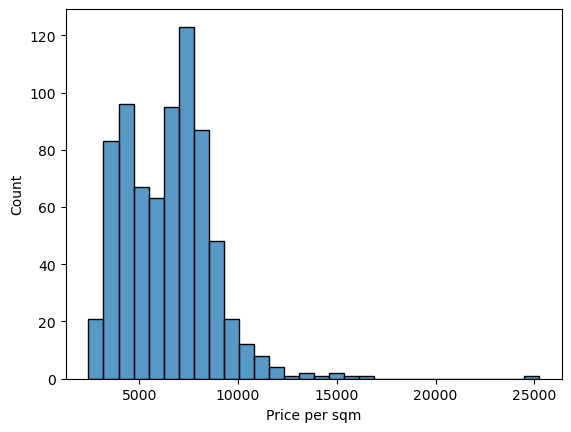

In [8]:
# plot 'Price per sqm' distribution as a histplot
plot = sns.histplot(x = data['Price per sqm'], bins = 30)

**Distribution is right-skewed**

In [9]:
data_info.loc['Price per sqm', 'distribution'] = 'right_skewed'

Check outliers of Price per sqm

In [10]:
count_outliers(data = data, data_info = data_info, features = ['Price per sqm'])

o 9 datapoints with Price per sqm > 12649.031296572282


,Address,Zip,Price,Area,Room,Lon,Lat,Price per sqm
22,"Pieter Cornelisz. Hooftstraat 169 B, Amsterdam",1071 BW,1695000.0,117,3,4.876144,52.358928,14487.179487
149,"Zocherstraat 23 X, Amsterdam",1054 LR,1200000.0,81,3,4.858004,52.357400,14814.814815
162,"Prins Hendrikkade 512, Amsterdam",1011 TE,389000.0,30,2,4.906059,52.374085,12966.666667
277,"Keizersgracht 544, Amsterdam",1017 EL,5950000.0,394,10,4.887378,52.365078,15101.522843
418,"Dam 5 V, Amsterdam",1012 JS,4495000.0,178,5,4.894290,52.373106,25252.808989
554,"Leonard Bernsteinstraat 96 A, Amsterdam",1082 MR,1750000.0,130,3,4.872151,52.336348,13461.538462
587,"Amstel 102, Amsterdam",1017 AD,2325000.0,150,6,4.896842,52.366965,15500.000000
589,"Huidekoperstraat 24 F, Amsterdam",1017 ZM,2475000.0,183,4,4.897473,52.358943,13524.590164
644,"Nieuwe Keizersgracht 570 L, Amsterdam",1018 VG,1050000.0,63,3,4.908850,52.365524,16666.666667


The biggest outlier is a house, located on a Dam square, which is the most famous square of Amsterdam, so it is normal, that it is so expencive. Besides that, according to google maps, this house is a new-build or recently renovated. All other houses in outliers list are mostly located in the city center or next to tourist attractions (like row with address Zocherstraat 23 - next to Vondelpark).

In [11]:
data_info.loc['Price per sqm', 'n outliers'] = 0
data_info

,data_type,missing values,distribution,n outliers
index,,,,
Price,continuous,3.0,right_skewed,0.0
Address,text,0.0,not applicable,0.0
Zip,text,0.0,not applicable,0.0
Area,continuous,0.0,right_skewed,1.0
Room,descrete,0.0,right_skewed,0.0
Lon,continuous,0.0,normal,2.0
Lat,continuous,0.0,heavy_tailed,0.0
Price per sqm,continuous,0.0,right_skewed,0.0


**a. Study correlations between numerical features:**

As in this dataset most of variables are not distributed normally, we have to use a custom function, that will dicide if Pearson's or Spearman's correlation test has to be applied:

In [12]:
correlations_df = custom_corr(data, data_info, data.columns)
correlations_df

,method,feature1,feature2,r-value,p-value,stat-sign,N
0,Spearman,Lon,Price,-0.025781,4.846616e-01,False,737
1,Spearman,Lon,Area,0.078756,3.253710e-02,True,737
2,Spearman,Lon,Room,0.014287,6.986006e-01,False,737
3,Spearman,Lon,Lat,-0.091303,1.315111e-02,True,737
4,Spearman,Lon,Price per sqm,-0.111327,2.473536e-03,True,737
5,Spearman,Price,Area,0.720851,3.896903e-119,True,737
6,Spearman,Price,Room,0.518670,5.467193e-52,True,737
7,Spearman,Price,Lat,0.062011,9.252604e-02,False,737
8,Spearman,Price,Price per sqm,0.437909,7.000172e-36,True,737
9,Spearman,Area,Room,0.773116,1.774729e-147,True,737


As we can see here, most of statistically signifficant correlations are between a feature and a target (in this case there are 2 targets: price and price per sqm). Longitude and Latitude have no impact on price, however both have impact on price per sqm. Also there is positive correlation between Area and Rooms which seems to be fair. This features might be transformed later.

Let's plot **Area** and **Room** features vs. Price to see the character of dependancy:

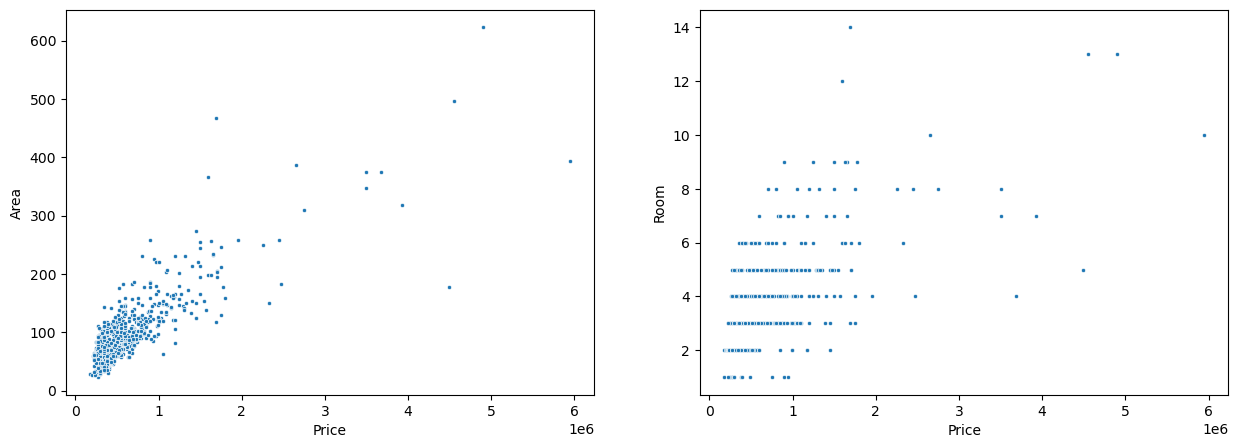

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
for count, feature in enumerate(['Area', 'Room']):
    sns.scatterplot(data = data, x = 'Price', y = feature, marker='.', ax = axes.flatten()[count])

Room has no signifficant impact on Price. Area seems to be positively correlated with the Price. Also, houses with the Price over 2M are mostly creating noise. It is better to normalize target and Area and plot again:

<Axes: xlabel='log_Price', ylabel='log_Area'>

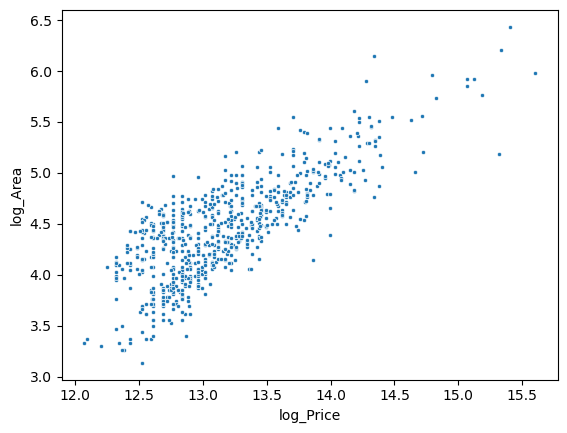

In [14]:
data['log_Price'] = np.log(data['Price'])
data_info.loc['log_Price', 'data_type'] = 'continuous'
data_info.loc['log_Price', 'missing values'] = 0

data['log_Area'] = np.log(data['Area'])
data_info.loc['log_Area', 'data_type'] = 'continuous'
data_info.loc['log_Area', 'missing values'] = 0

sns.scatterplot(data = data, x = 'log_Price', y = 'log_Area', marker='.')

Now the correlation is crlearly positive, containing some outliers though.
Let's try to discover if Area-Room ratio would work better than 2 separate features:

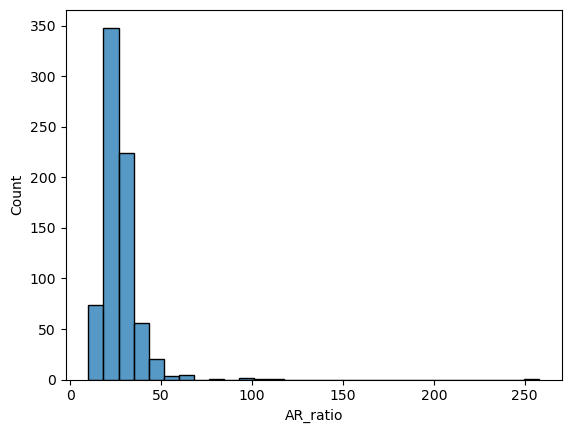

In [15]:
data['AR_ratio'] = data['Area'] / data['Room']
plot = sns.histplot(x = data['AR_ratio'], bins = 30)

There are clearly some outliers that can drive the distribution. Let's check if that's true:
1. create a corr matrix with features of interest and target with outliers
2. remove all outliers and leverage points of feature
3. create new corr matrix
4. calculate the delta of 2 matrixes to define if the outliers are influential

In [ ]:
# 1. create a corr matrix with features of interest and target with outliers

In [ ]:
sns.scatterplot(data = data, x = 'log_Price', y = 'AR_ratio', marker='.')

Here is clearly an outlier at the top, but the others are not clear. Let's apply the outliers detection function to the feature:

In [ ]:
# add info about the feature, that is needed to define the type of distribution
data_info.loc['AR_ratio', 'data_type'] = 'continuous'
data_info.loc['AR_ratio', 'missing values'] = 0
data_info.loc['AR_ratio', 'distribution'] = 'right_skewed'

count_outliers(data = data, data_info = data_info, features = ['AR_ratio'])

Check if these outliers have signifficant impact:

In [ ]:
data.drop(data.loc[data['AR_ratio']>45].index, inplace = True)

# reset indexes after removing rows
data = data.reset_index()
data = data.drop(columns=['index'])

# plot AR-ratio without the biggest outlier vs. log_Price
sns.scatterplot(data = data, x = 'log_Price', y = 'AR_ratio', marker='.')

In [ ]:
plot = sns.histplot(x = data['AR_ratio'], bins = 50)

In [ ]:
normality_check(data, data_info, ['AR_ratio'])

Let's check the correlation of this feature:

In [ ]:
data_info.loc['AR_ratio', 'data_type'] = 'continuous'
data_info.loc['AR_ratio', 'missing values'] = 0
normality_check(data, data_info, ['AR_ratio'])
data_info

In [ ]:
correlations_df = custom_corr(data, data_info, ['Price', 'Area', 'Room', 'AR_ratio'])
correlations_df

Area still has the biggest impact on the target and as long as **all 3 features are correlated to each other**, we have to choose only 1 of them. At this point, this will be the Area feature.

Now let's discover **Lon** and **Lat** features. As the correlation analysis says, there is no dependency of Price on any of the two. Let's discover a plot of Lat vs Lon to see the 'city map' of the house prices. 

In [ ]:
# plot longitude vs latitude and hue by price
sns.scatterplot(data = data, x = 'Lon', y = 'Lat', hue = 'log_Price')

center_lat = data['Lat'].mean()
center_lon = data['Lon'].mean()

plt.scatter(x = center_lon, y = center_lat, color = 'r', label = 'city center')

This plot is more informative: the darkest points are mostly located on the outskirts and **central** ones are more **expencive**. There are deffinetely some outliers in the top right corner of the plot.
Lat and Lon features can be used for engineering of an additional feature called 'Distance from city center'. Most popular formulas for calculating diistance between 2 points are Euclidean and Manhattan distance. There is also Haversine formula to count distance between 2 poins on the map having their latitude and longitude. Let's count 3 of them and defice which correlates better with the Target:

**Haversine formula**:

a = sin²(Δφ/2) + cos φ1 ⋅ cos φ2 ⋅ sin²(Δλ/2)

c = 2 ⋅ atan2( √a, √(1−a) )

d = R ⋅ c

where φ is latitude, λ is longitude, R is earth’s radius (mean radius = 6,371km);

**Euclidean distance**:

d = √[(φ1 - φ2)² + (λ1 - λ2)²]

**Manhattan distance**:

d = |φ1 - φ2| + |λ1 - λ2|

In [ ]:
def distance_betw_2points(point_lat: float, center_lat: float, point_lon: float, center_lon: float, method: str = 'Euclidean') -> float:

    if method in ['Euclidean', 'Manhattan', 'Haversine']:

        if method == 'Euclidean':
            # formula tailored for distances on map
            deglen = 110.25
            x = center_lat - point_lat
            y = (center_lon - point_lon) * np.cos(center_lon)
            d = deglen * np.sqrt(x * x + y * y)
            return d

        elif method == 'Haversine':
        
            # φ, λ in radians
            center_lat = center_lat * pi/180
            center_lon = center_lon * pi/180

            point_lat = point_lat * pi/180
            point_lon = point_lon * pi/180
            delta_lat = np.abs(point_lat - center_lat)
            delta_lon = np.abs(point_lon - center_lon)


            R = 6371e3 # in meters
            a = np.square(np.sin(delta_lat/2)) + np.cos(point_lat) * np.cos(center_lat) * np.square(np.sin(delta_lon/2))
            c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
            d = R * c

            return d
        
        else:

            d = np.abs(center_lat - point_lat) + np.abs(center_lon - point_lon)
            return d  
        
    else: 
        print('Method not in [Euclidean, Manhattan, Haversine]')

In [ ]:
# generate distance features
data = data.assign(
    **{
        "Euclidean_distance": lambda df: distance_betw_2points(
            df["Lat"], center_lat, df["Lon"], center_lon, method='Euclidean'
        ),
        "Manhattan_distance": lambda df: distance_betw_2points(
            df["Lat"], center_lat, df["Lon"], center_lon, method='Manhattan'
        ),
        "Haversine_distance": lambda df: distance_betw_2points(
            df["Lat"], center_lat, df["Lon"], center_lon, method='Haversine'
        )
    }
)

data.head()

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(17, 4))
for count, feature in enumerate(data.columns[-3:]):
    sns.scatterplot(data = data, x = 'log_Price', y = feature, marker='.', ax = axes.flatten()[count])

There is negative correlation between log_Price and each distance feature. Let's update the correlation matrix with the new features and define which of 3 impacts the target the most:

In [ ]:
# in order to get correlations, we have to know the type of distribution of new features

data_info.loc['Euclidean_distance', 'data_type'] = 'continuous'
data_info.loc['Manhattan_distance', 'data_type'] = 'continuous'
data_info.loc['Haversine_distance', 'data_type'] = 'continuous'
data_info.loc['Euclidean_distance', 'missing values'] = 0
data_info.loc['Manhattan_distance', 'missing values'] = 0
data_info.loc['Haversine_distance', 'missing values'] = 0

data_info = normality_check(data = data, data_info = data_info, features=data.columns[-3:], )

In [ ]:
custom_corr(data, data_info, ['log_Price', 'log_Area', 'Euclidean_distance', 'Manhattan_distance', 'Haversine_distance'])

Here we can see, that Manhattan_distance has the strongest correlation with the target. It is also correlated with the 'log_Area', however the signifficance is very close to the threshold of 0.05, so we can ignore this correltion. So at this point we **remove the following features:**
 - Euclidean_distance
 - Haversine_distance

In [ ]:
data = data.drop(columns=['Euclidean_distance', 'Haversine_distance'])

Define the **outliers** of the new feature:

In [ ]:
# because the distribution is not normal, lets plot it and manualy define the subtype, which is needed to find the outliers:

sns.histplot(x = data['Manhattan_distance'], bins = 30)

In [ ]:
data_info.loc['Manhattan_distance', 'distribution'] = 'right_skewed'

count_outliers(data, data_info, ['Manhattan_distance'])

Point 108 and 377 are far from city center as they are located in the Region 1, which is a little bit outside of the city. However the point 422 is in the Region 0 (for Amsterdam) and it has maximum value of Lat and one of the biggest values of Lon. that is the dot in the top right cornet of the 'lat vs. Lon' scatterplot. Let's remove this outlier:

In [ ]:
data = data.drop([422], axis=0)

# reset indexes after removing rows
data = data.reset_index()
data = data.drop(columns=['index'])

data = data.drop(columns=['Lat', 'Lon'])
data.sample()

**b. Study dependency of target on the nominal features:**

As it was found out in EDA, the Address is unoque for every datapoint, so it cannot be used as a predictor. However the Zip code has a pattern: The first two digits indicate a `City` and a `Region`, the third digit represents the `Location` and the fourth - `District`. The first letter indicates the `delivery area`, and the second letter indicates the subdivision of the delivery area. Consequently, the postcode and house number uniquely define a postal address. Let's us create several features based on subsection of the Zip code ([source](https://en.youbianku.com/Netherlands))

**Option 1**: Divide Zip to city, region, location, district, delivery area

In [ ]:
# 1. create a copy of data to experiment with Zip
data1 = data.copy().drop(columns=['Address'])
data1.sample()

In [ ]:
# 2. transform Zip
data1['Zip city'] = np.nan
data1['Zip region'] = np.nan
data1['Zip location'] = np.nan
data1['Zip district'] = np.nan
data1['Delivery area'] = ''
for row in range(data1.shape[0]):
    data1.loc[row, 'Zip city'] = str(data1.loc[row, 'Zip'][0])
    data1.loc[row, 'Zip region'] = str(data1.loc[row, 'Zip'][1])
    data1.loc[row, 'Zip location'] = str(data1.loc[row, 'Zip'][2])
    data1.loc[row, 'Zip district'] = str(data1.loc[row, 'Zip'][3])
    data1.loc[row, 'Delivery area'] = str(data1.loc[row, 'Zip'][-2:])
data1 = data1.drop(columns=['Zip'])
data1.sample

display(data1['Zip city'].value_counts())
display(data1['Zip region'].value_counts())
display(data1['Zip location'].value_counts())
display(data1['Zip district'].value_counts())
display(data1['Delivery area'].value_counts())

Zip city is always 1, so has no predictive power. Let's remove it:

In [ ]:
data1 = data1.drop(columns=['Zip city'])

Let's now check if the rest of new features have impact on target. For this purpose custom function will be applied, which first checks if the variances of the variable groups are equal, and then performs either normal ANOVA or Welch ANOVA. It is also better to normalize the target by transforming it with logarithm function:

In [ ]:
data1['log_Price'] = np.log(data1['Price'])

In [ ]:
def custom_anova(data: pd.DataFrame, grouping_var: list, feature: str, result_table: pd.DataFrame, plot: bool = True) -> pd.DataFrame:

    for col in grouping_var:

        # check is variances are homogeneous
        values_per_group = {
            grp_label: values
            for grp_label, values in data.groupby(col, observed=True)['Price']
        }
        
        # create a list with lists of values
        (levene, levene_p_value) = stats.levene(*values_per_group.values())
        if levene_p_value >0.05:
            variances = 'equal'
        else:
            variances = 'not_equal'

        # normal ANOVA can be applied only when the variances are homogeneous
        if variances == 'equal':
            test_type = 'One way ANOVA'
            (f_value, p_value) = stats.f_oneway(*values_per_group.values())
        else:
            test_type = 'Welch ANOVA'
            welch_df = pg.welch_anova(dv = feature, between = col, data = data)
            p_value = welch_df['p-unc']
            f_value = welch_df['F']

        dict_result = {
            "test-type": test_type,
            "feature": col,
            "group-var": feature,
            "f-value": round(f_value, 3),
            "p-value": round(p_value, 5),
            "stat-sign": (p_value < 0.05),
            "variances": variances
        }
        df_result = pd.DataFrame(data=dict_result, index=[0])
        result_table = pd.concat([result_table, df_result], ignore_index=True) 

        # plot grouping var vs feature as boxplots
        if plot:
            boxplot, ax = plt.subplots(figsize = (15,4))
            _ = sns.boxplot(ax=ax, x=data[col], y=data[feature])
            _ = sns.swarmplot(
                ax=ax, x=data[col], y= data[feature], color=".25", alpha=0.50, size=2
            )
            _ = ax.set_title(f"Boxplot {feature} across {col}")
            plt.xticks(rotation=90)

    return result_table

In [ ]:
anova_df = pd.DataFrame()
anova_df = custom_anova(data1, ['Zip region', 'Zip location', 'Zip district', 'Delivery area'], 'log_Price', anova_df)
anova_df

The analysis says that the Zip region and Zip location are statistically signifficant. However, if one take a look at the Zip location boxplot, one can find out that the groups are barely different. So, it only makes sence to have Zip region, which is binary and simply means if the house is located in Zuid-ost (1) or in any other district of Amsterdam (0).

**Option 2:** Nevertheless, if one is attentive enough, one could notice that according to the [city map](https://slotenmaker365-amsterdam.nl/wp-content/uploads/2018/04/map-amsterdam.png) the 3rd and 4th digits together create a unique number. It always starts with 0 for Zuid-oost and with 1-9 for the rest of the city. And the bigger this number is, the futher from the city center is the house. This assumption is the next one to be checked:

In [ ]:
data1['Zip new'] = data1['Zip location']+data1['Zip district']
data1 = data1.drop(columns=['Zip region', 'Zip location', 'Zip district', 'Delivery area'])
data1.sample()

In [ ]:
anova_df = custom_anova(data = data1, grouping_var = ['Zip new'], feature='log_Price', result_table=anova_df)
anova_df


Even though the ANOVA analysis says that is a statistically significant feature, there are still too many groups, and some of them have really little observations, while some have a huge inside-the-group variance.

**Option 3:** There is one more possibility: to cluster zip codes by the city districts. There are [8 districts](https://www.amsterdamsights.com/maps/districts.jpg) in Amsterdam: Centrum, Noord, West, Zuid, Oost, Nieuw-West, Westpoort (non-residential area), and Zuidoost. Let's cluster the Zips manualy to these districts:

In [ ]:
# to define the district, we only need the number part of the Zip code

for row in range(data1.shape[0]):
    data1.loc[row, 'Zip num'] = str(data.loc[row, 'Zip'][:4])

data1 = data1.drop(columns=['Zip new'])
data1.sample()

In [ ]:
# first version of possible clustering
data1['District_v1'] = 'undefined'

data1.loc[
        lambda x: x["Zip num"].isin(['1011', '1012', '1015', '1016', '1017', '1018']), "District_v1"
    ] = "Centrum"

data1.loc[
        lambda x: x["Zip num"].isin(['1021', '1022', '1023', '1024', '1025', '1026', '1027', '1028', '1029', '1031', '1032', '1033', '1034', '1035', '1036']), "District_v1"
    ] = "Noord"

data1.loc[
        lambda x: x["Zip num"].isin(['1013', '1014', '1051', '1052', '1053', '1054', '1055', '1056', '1057']), "District_v1"
    ] = "West"

data1.loc[
        lambda x: x["Zip num"].isin(['1058', '1059', '1071', '1072', '1073', '1074', '1075', '1076', '1077', '1078', '1079', '1081', '1082', '1083']), "District_v1"
    ] = "Zuid"

data1.loc[
        lambda x: x["Zip num"].isin(['1019', '1086', '1087', '1091', '1092', '1093', '1094', '1095', '1096', '1097', '1098']), "District_v1"
    ] = "Oost"

data1.loc[
        lambda x: x["Zip num"].isin(['1060', '1061', '1062', '1063', '1064', '1065', '1066', '1067', '1068', '1069']), "District_v1"
    ] = "Nieuw-West"

data1.loc[
        lambda x: x["Zip num"].isin(['1101', '1102', '1103', '1104', '1105', '1104', '1105', '1106', '1107', '1108', '1109']), "District_v1"
    ] = "Zuid-Oost"


In [ ]:
# make sure each observation belongs to one of the groups
data1['District_v1'].value_counts()

In [ ]:
anova_df = custom_anova(data=data1, grouping_var=['District_v1'], feature='log_Price', result_table=anova_df)
anova_df

Let's analyze the plot: Centrum and Zuid are pretty simmilar, also Oost, West, Nieuw-West and Noord could be clustered together. So we'll now have 3 clusters: Centrum+Zuid, Zuid-Oost, and the rest

In [ ]:
# clustering a new way
data1['District_v2'] = ''

data1.loc[
        lambda x: x["District_v1"].isin(['Centrum', 'Zuid']), "District_v2"
    ] = "Centrum + Zuid"

data1.loc[
        lambda x: x["District_v1"].isin(['Noord', 'West', 'Oost', 'Nieuw-West']), "District_v2"
    ] = "the rest"

data1.loc[
        lambda x: x["District_v1"].isin(['Zuid-Oost']), "District_v2"
    ] = "Zuid-Oost"


In [ ]:
anova_df = custom_anova(data=data1, grouping_var=['District_v2'], feature='log_Price', result_table=anova_df)
anova_df

These groups look more different than the previous ones. The p-value is still very close to 0, so this could be a good clustering. There is also a possibility to change the target to price per square meter, but that will be done later, not for a benchmark model.

**4. Create a benchmark model**

Let's create an initial model and measure the benchmark accuracy. The model will not contain custom features (Price per sqm and Distance from center) and will only require text data transformation and scaling of numerical features:
 1. Address wil be removed as it is unique for every datapoint, so has no predictive power
 2. Zip code will be cut to just numbers and checked if it is correlated with target (every digit in the Zip code has its own meaning, so instead of 1 feature there would be 4)
 3. Price, Area and Room features will be normalized.

**Option 1:** 
- logarithm of Price
- logarithm of Area
- Manhattan distance
- one-hot-encoded District_v2, as it showed better variance

In [ ]:
# 1. remove extra or unimportant columns

train_data1 = data1.drop(columns=['Room', 'Price per sqm', 'Zip num', 'District_v1'])
train_data1.sample()

In [ ]:
correlations_df = custom_corr(train_data1, data_info, features=['log_Price', 'log_Area', 'Manhattan_distance'])
correlations_df

According to correlation matrix, the data is ready to be fed to the initial model to get benchmark accuracy. But first the `District` feature has to be one hot encoded:

In [ ]:
district = pd.get_dummies(train_data1['District_v2'], drop_first=True, dtype=int, prefix='District')
train_data1 = pd.concat([train_data1, district], axis = 1)
train_data1.sample()

In [ ]:
X1 = train_data1.drop(columns=['Price', 'log_Price', 'Area', 'District_v2'])
y1 = train_data1['log_Price']
model1 = LinearRegression()

In [ ]:
results = pd.DataFrame()
results['Model'] = ''
results['N folds'] = 0
results['List of used features'] = []
results['RMSE'] = np.nan
results['MAE'] = np.nan
results['r2_coef_determination'] = np.nan
results['explained_variance'] = np.nan
results['corr_coef'] = np.nan

In [ ]:
rmse1, mae1, r2_coef_determination1, explained_variance1, corr1 = evaluate_model(model1, X1, y1, results, cv = 4)
results

This model is no good. There is almost 300k error in price, which is quite a lot.

**Option 2:** 
- logarithm of Price
- logarithm of Area
- Manhattan distance
- one-hot-encoded District_v1, to see if it could work better

In [ ]:
train_data2 = data1.drop(columns=['Room', 'Price per sqm', 'Zip num', 'District_v2'])
train_data2['log_Area'] = np.log(train_data2['Area'])
train_data2.sample()

In [ ]:
district = pd.get_dummies(train_data2['District_v1'], drop_first=True, dtype=int, prefix='District')
train_data2 = pd.concat([train_data2, district], axis = 1)
train_data2.sample()

In [ ]:
X2 = train_data2.drop(columns=['Price', 'log_Price', 'Area', 'District_v1'])
y2 = train_data2['log_Price']
model2 = LinearRegression()

In [ ]:
rmse2, mae2, r2_coef_determination2, explained_variance2, corr2 = evaluate_model(model2, X2, y2, results, cv = 4)
results

Even though the plot showed that clustering for 3 districts is more predictive, the model evaluation says the opposite: all the metrics are now improved. 

In [ ]:
# # save all the dataframes for futher use

# results.to_csv("./data/results.csv", index=False)
# data_info.to_parquet("./data/data_info.parquet")
# data1.to_csv("./data/data_train.csv", index=False)


## Summary:


1. Area and Room features are correlated, instead Area-Room ratio could be created.
2. Lon, Lat, Address have no impact on target.
3. It can be prommising to create a 'Distance' feature out of Lon and Lat.
4. The whole Zip code has no influence on the target as well. However, it is possible to define the district out of Zip code, which is more predictive.
5. Price per square meter could be an alternative target. This assumption still requires a proof.